In [1]:
#Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff 

from sklearn.preprocessing import OneHotEncoder


import warnings
warnings.filterwarnings('ignore')

In [42]:
# Define tamanho padrão dos plotes
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [43]:
# Descomentar para rodar direto do collab
#urllib.request.urlretrieve("https://raw.githubusercontent.com/tadj8/mpd/main/dataset_6_letter.arff", "datasets/phpCsX3fx.arff")

raw_data = loadarff("datasets/collins.arff")
df_data = pd.DataFrame(raw_data[0])

In [44]:
df_data

,Text,FirstPerson,InnerThinking,ThinkPositive,ThinkNegative,ThinkAhead,ThinkBack,Reasoning,Share_SocTies,Direct_Activity,...,SpaceInterval,Motion,PastEvents,TimeInterval,ShiftingEvents,Text_Coverage,Genre,Counter,Corpus,Corp.Genre
0,b'A01.TXT',0.09,1.72,0.62,0.70,2.15,0.66,1.23,2.24,0.48,...,0.75,0.35,2.55,1.63,0.79,28.31,b'1',1.0,b'1',b'101'
1,b'A02.TXT',0.13,1.48,0.38,0.63,1.85,0.93,1.48,2.28,0.21,...,0.59,0.25,1.77,1.39,0.80,23.91,b'1',2.0,b'1',b'101'
2,b'A03.TXT',0.04,1.72,0.34,1.12,1.55,0.90,1.68,2.84,0.17,...,0.65,0.17,2.32,1.94,0.82,30.15,b'1',3.0,b'1',b'101'
3,b'A04.TXT',0.00,2.74,0.90,2.43,1.21,1.03,3.46,3.06,0.22,...,0.67,0.09,1.89,1.71,0.81,29.43,b'1',4.0,b'1',b'101'
4,b'A05.TXT',0.26,2.15,0.39,0.61,2.28,0.75,1.93,1.84,0.44,...,0.75,0.35,1.54,1.80,0.96,27.89,b'1',5.0,b'1',b'101'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b'rFR5.txt',0.49,3.25,0.41,2.10,1.07,0.25,3.29,1.93,1.65,...,0.70,0.90,1.19,1.77,1.07,34.11,b'15',996.0,b'2',b'215'
996,b'rFR6.txt',5.17,4.86,1.08,0.99,1.26,0.45,3.51,1.17,0.00,...,1.26,0.18,1.35,1.08,1.26,38.95,b'15',997.0,b'2',b'215'
997,b'rFR7.txt',0.00,2.70,1.30,1.21,1.21,1.30,2.16,1.35,0.18,...,1.08,0.31,5.13,1.71,1.08,40.36,b'15',998.0,b'2',b'215'
998,b'rFR8.txt',0.73,1.96,0.41,0.37,1.06,0.65,2.04,0.86,0.08,...,3.02,1.02,4.41,0.61,0.41,42.53,b'15',999.0,b'2',b'215'


In [47]:
df = df_data.copy()

# Nosso target:
#    Genre : The genre of each text (assigned by the Brown corpus compilers)

# Gênero é categórica e não tem ordinalidade entre as classes. Portanto, decidimos usar OneHotEncoding para transformar
# em numérica:
df = df.join(pd.get_dummies(df['Genre']))

# Remove colunas que não utilizaremos:
#   Genre : removemos coluna com valores categoricos
#   Text : nome do texto de origem
#   Corpus : 1=Brown, 2=Frown
#   Corp.Genre : mesmo que a coluna Genre, só codificada diferente
#
df.drop(['Text', 'Corpus', 'Counter', 'Corp.Genre', 'Genre'], axis=1, inplace=True)


,Text,FirstPerson,InnerThinking,ThinkPositive,ThinkNegative,ThinkAhead,ThinkBack,Reasoning,Share_SocTies,Direct_Activity,...,b'14',b'15',b'2',b'3',b'4',b'5',b'6',b'7',b'8',b'9'
0,b'A01.TXT',0.09,1.72,0.62,0.70,2.15,0.66,1.23,2.24,0.48,...,0,0,0,0,0,0,0,0,0,0
1,b'A02.TXT',0.13,1.48,0.38,0.63,1.85,0.93,1.48,2.28,0.21,...,0,0,0,0,0,0,0,0,0,0
2,b'A03.TXT',0.04,1.72,0.34,1.12,1.55,0.90,1.68,2.84,0.17,...,0,0,0,0,0,0,0,0,0,0
3,b'A04.TXT',0.00,2.74,0.90,2.43,1.21,1.03,3.46,3.06,0.22,...,0,0,0,0,0,0,0,0,0,0
4,b'A05.TXT',0.26,2.15,0.39,0.61,2.28,0.75,1.93,1.84,0.44,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b'rFR5.txt',0.49,3.25,0.41,2.10,1.07,0.25,3.29,1.93,1.65,...,0,1,0,0,0,0,0,0,0,0
996,b'rFR6.txt',5.17,4.86,1.08,0.99,1.26,0.45,3.51,1.17,0.00,...,0,1,0,0,0,0,0,0,0,0
997,b'rFR7.txt',0.00,2.70,1.30,1.21,1.21,1.30,2.16,1.35,0.18,...,0,1,0,0,0,0,0,0,0,0
998,b'rFR8.txt',0.73,1.96,0.41,0.37,1.06,0.65,2.04,0.86,0.08,...,0,1,0,0,0,0,0,0,0,0


In [40]:
df.shape

(1000, 24)

In [20]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_data)
profile.to_file('report_corpus.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


In [12]:
sum(df_data['First_quartile-Math_SAT'].isna())

530

In [70]:
print("Classes    : %d" % (len(df_data['class'].unique())))
print("Instancias : %d" % (len(df_data)))
print("Atributos  : %d" % (df_data.shape[1]))
print("Atributos  : %s" % ([k for k in df_data.keys()]))

Classes    : 26
Instancias : 20000
Atributos  : 17
Atributos  : ['x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx', 'class']


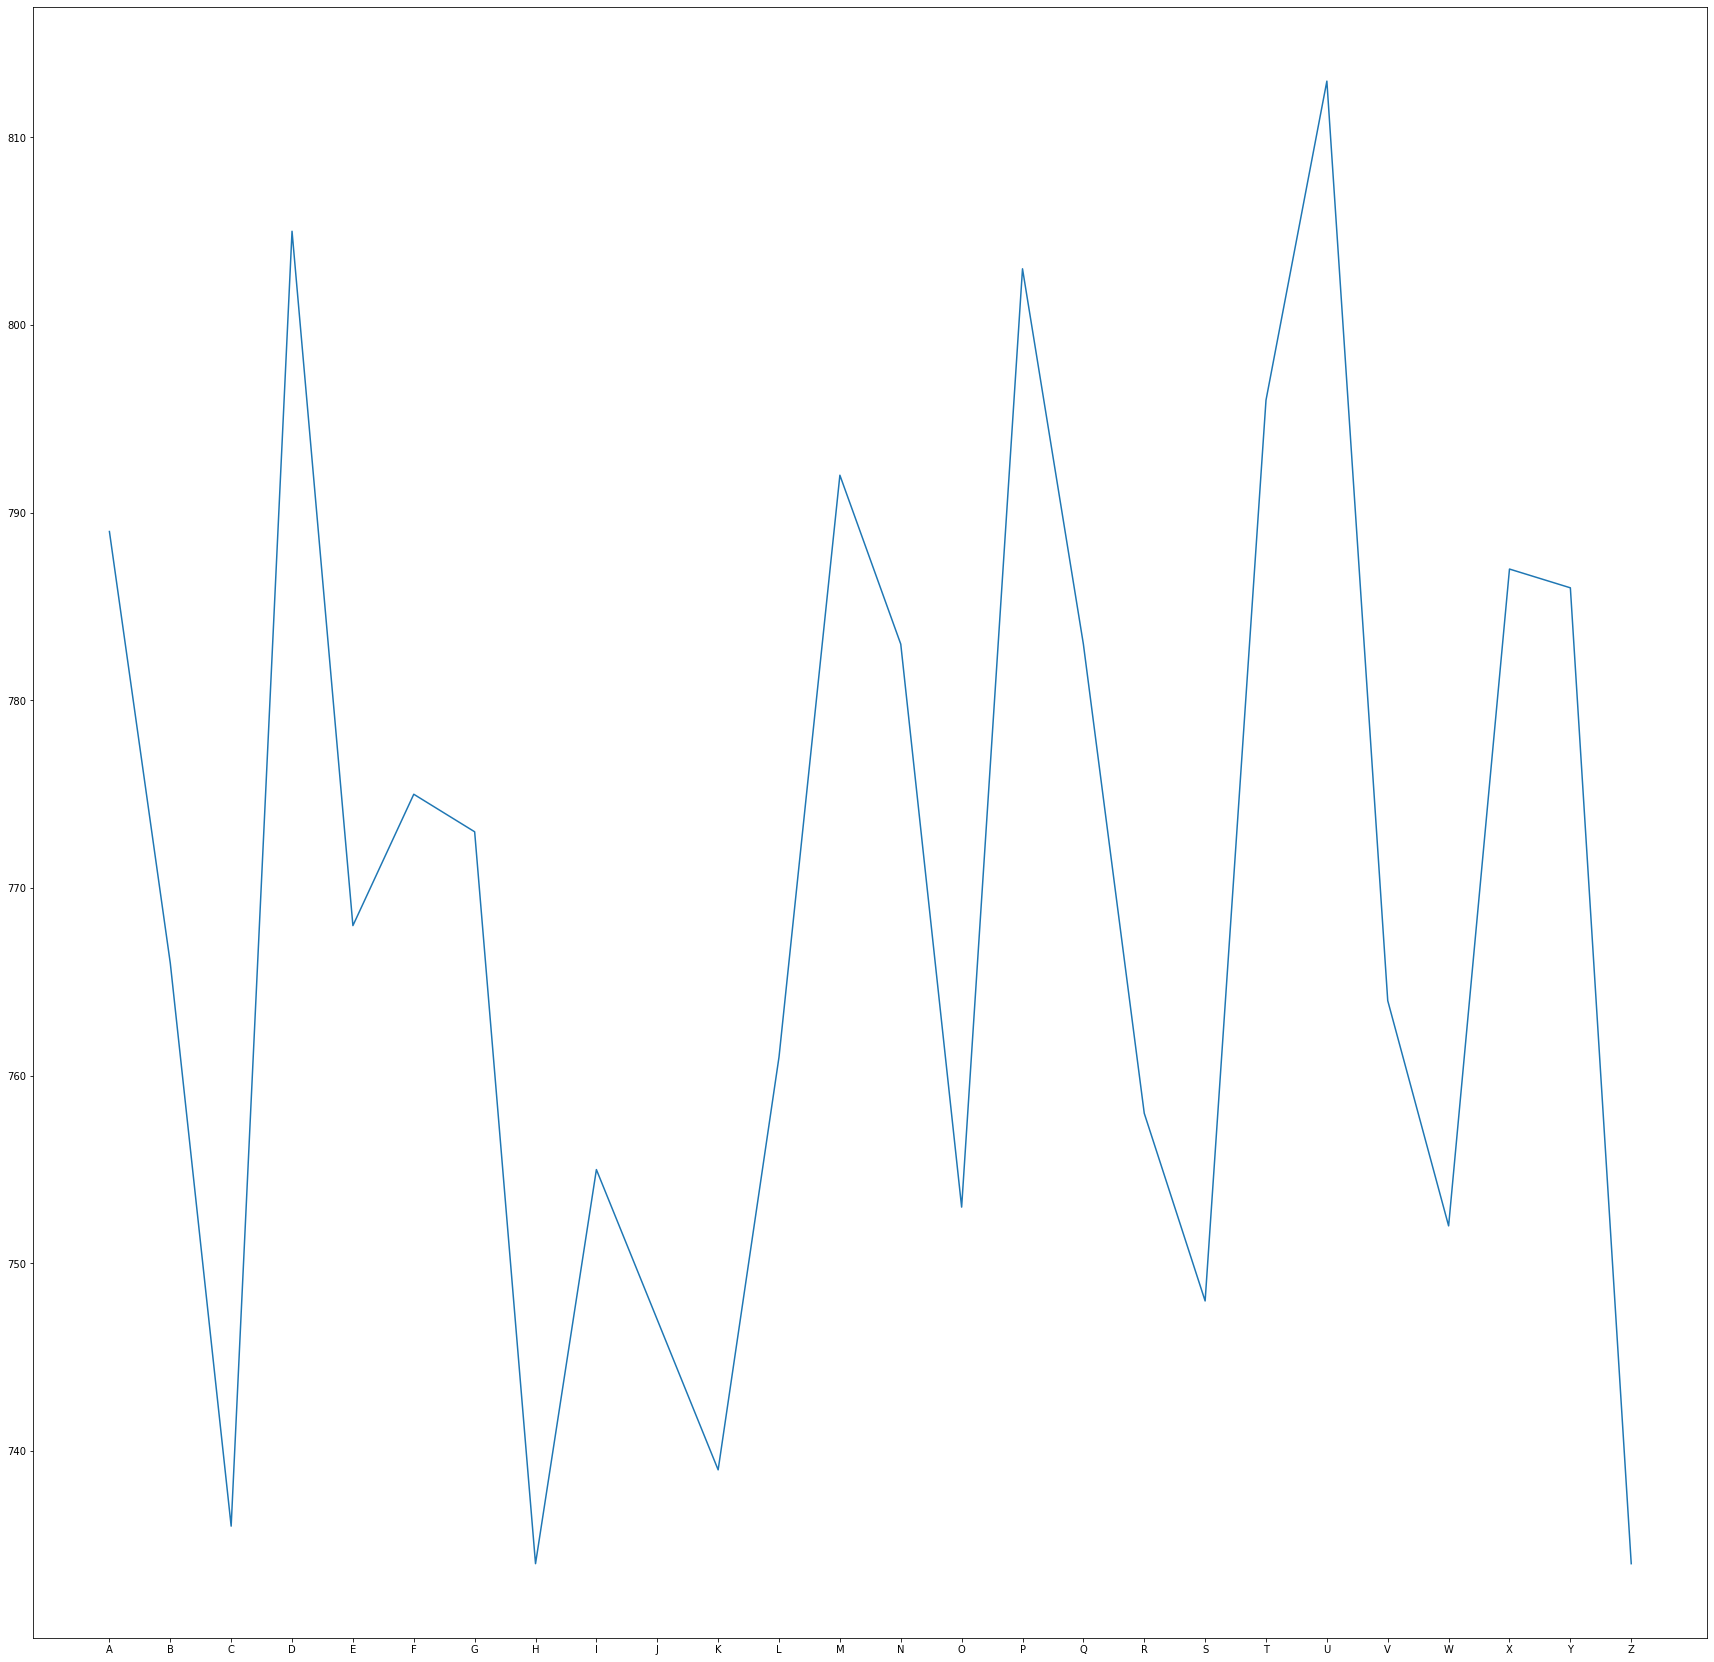

In [71]:
# Visualizando balanceamento das classes
sns.lineplot(data=df_data['class'].value_counts())

In [74]:
# Seleciona atributos de interesse
X = df_data.iloc[:,0:16]

# Converte classes para valores numericos
y = pd.factorize(df_data['class'])[0]
# y = df_data['class'].apply(int)

In [75]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

In [77]:
model = skn.KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [78]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       185
           1       0.96      0.93      0.94       228
           2       0.98      0.98      0.98       193
           3       0.88      0.85      0.86       195
           4       0.92      0.96      0.94       198
           5       0.94      0.92      0.93       202
           6       0.86      0.94      0.90       197
           7       0.99      0.97      0.98       190
           8       0.89      0.97      0.93       219
           9       0.95      0.96      0.96       200
          10       0.98      0.99      0.99       196
          11       0.92      0.90      0.91       196
          12       0.91      0.94      0.92       173
          13       0.90      0.94      0.92       175
          14       0.97      0.95      0.96       191
          15       0.98      0.96      0.97       189
          16       0.97      0.95      0.96       191
          17       0.96    

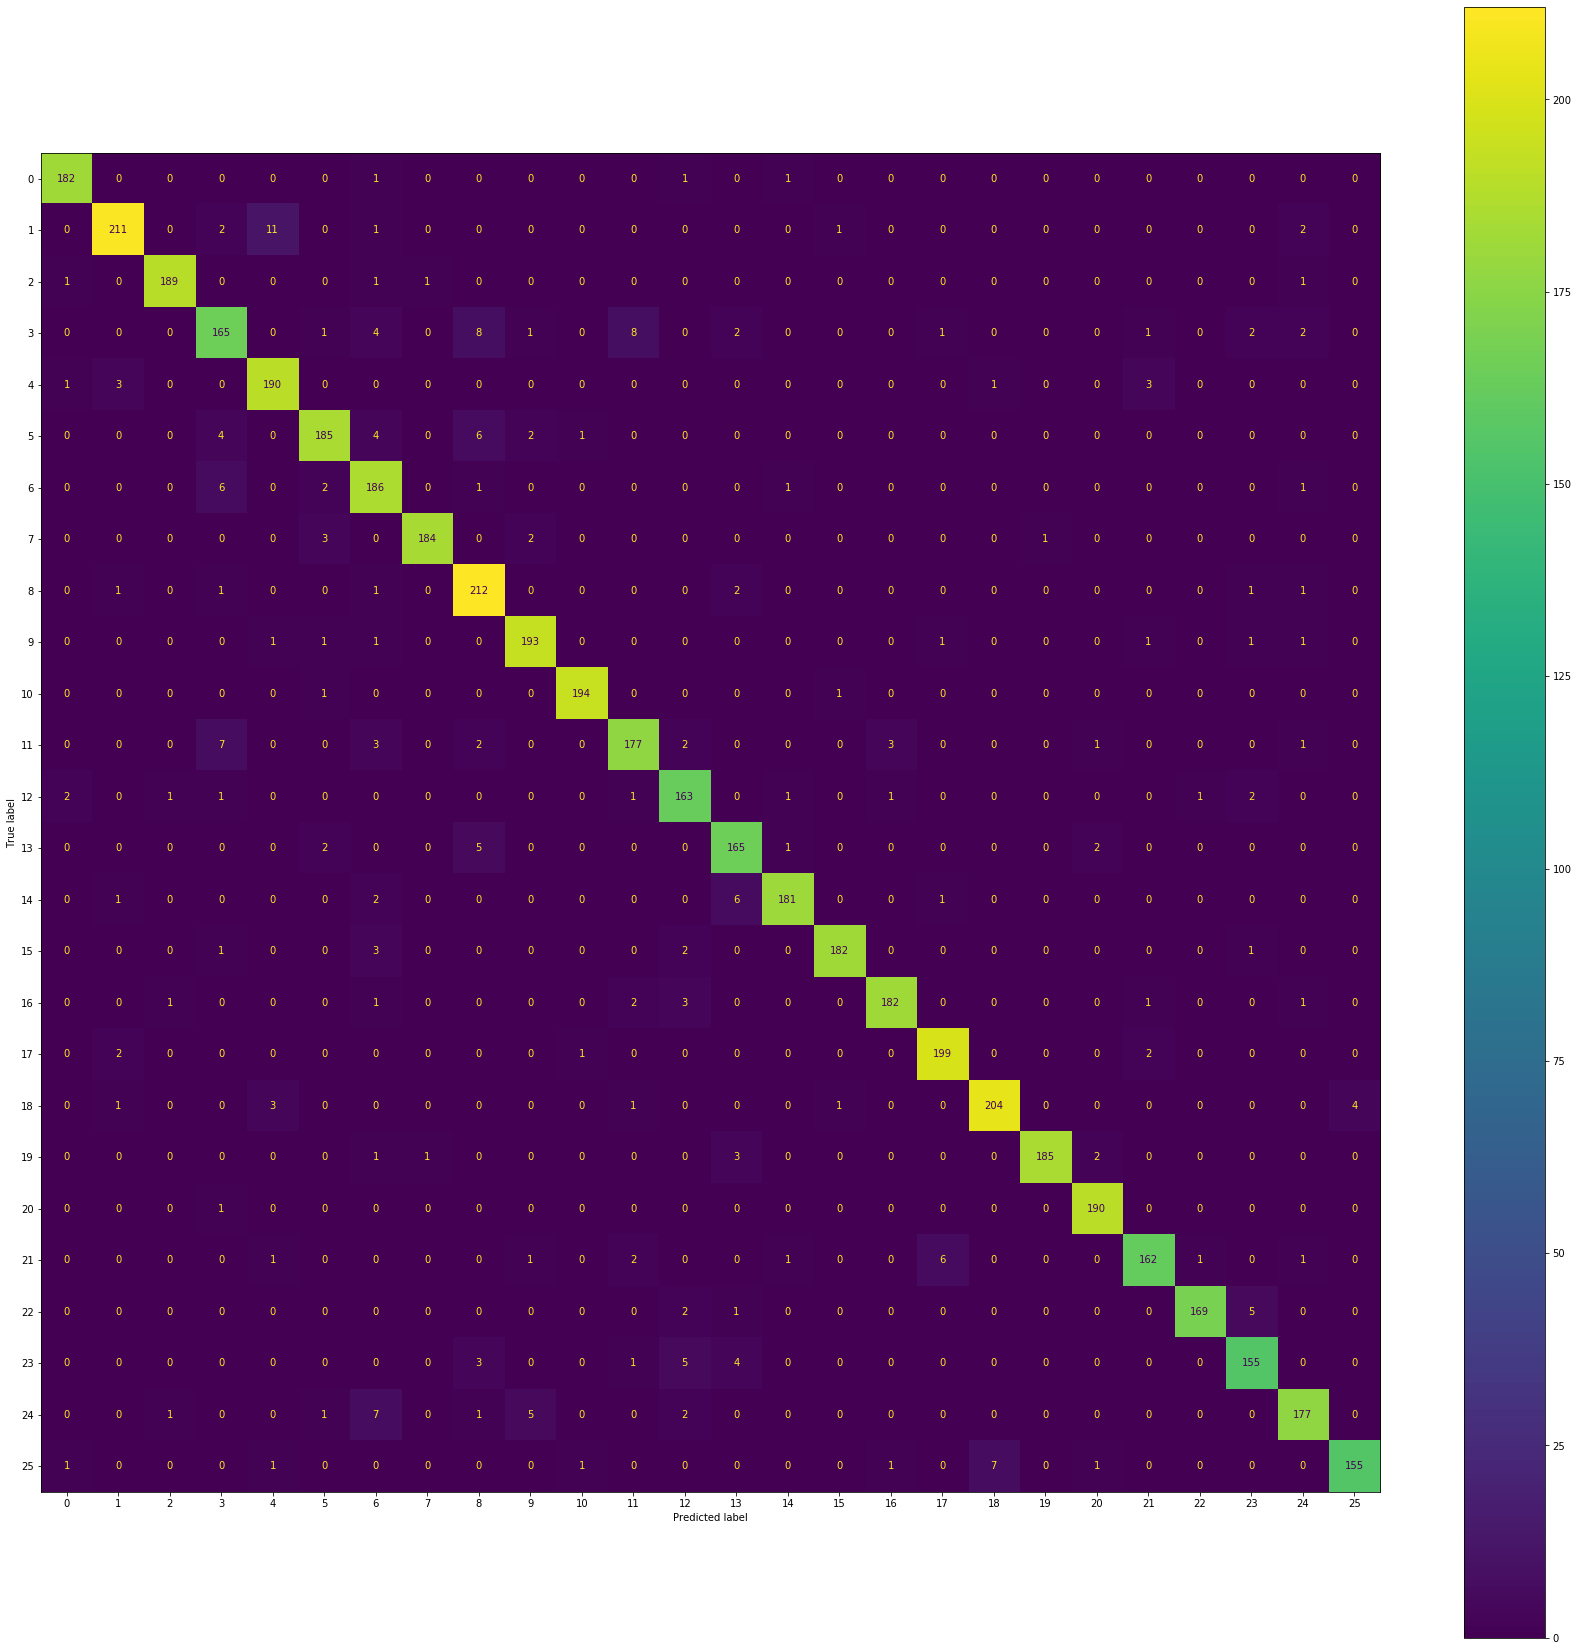

In [79]:
plt.rcParams['figure.figsize'] = [30, 30]
sklearn.metrics.plot_confusion_matrix(model, X_test, y_test)